# Intro

This notebook walks the reader through a full implementation of the original Neural Radiance Field architecture, first introduced by Mildenhall et al. in "[NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis.](https://www.matthewtancik.com/nerf)" 

Much of the code comes from or is inspired by the original implementation by GitHub user [bmild](https://github.com/bmild/nerf) as well as PyTorch implementations from GitHub users [yenchenlin](https://github.com/bmild/nerf) and [krrish94](https://github.com/krrish94/nerf-pytorch/). The code has been modified for clarity and consistency.

Based on:  
[This colab notebook](https://colab.research.google.com/drive/1TppdSsLz8uKoNwqJqDGg8se8BHQcvg_K?usp=sharing#scrollTo=jVAGjdUthecA)

## Imports

In [1]:
%matplotlib inline
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange
import random

# For repeatability
seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Debugging and logging 
import logging
from logging import debug
# logging.basicConfig(filename='logs.log', encoding='utf-8', level=logging.DEBUG)
logging.basicConfig(filename='logs.log', encoding='utf-8', level=logging.ERROR)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# Imputs

## Data
First we load the data which we will train our NeRF model on. This is the Lego bulldozer commonly seen in the NeRF demonstrations and serves as a sort of "Hello World" for training NeRFs. Covering other datasets is outside the scope of this notebook, but feel free to try others included in the original [NeRF source code](https://github.com/bmild/nerf) or your own datasets.

In [2]:
if not os.path.exists('tiny_dnerf_data.npz'):
	!wget https://github.com/ivanvoid/Tiny_Kilo-D-NeRF-NGP/blob/main/tiny_dnerf_data.npz

This dataset consists of 106 images taken of the synthetic Lego bulldozer along with poses and a common focal length value. Like the original, we reserve the first 100 images for training and a single test image for validation.

In [3]:
data = np.load('tiny_dnerf_data.npz')
data

NpzFile 'tiny_dnerf_data.npz' with keys: images, poses, times, focal

Images shape: (81, 100, 100, 3)
Poses shape: (81, 4, 4)
Focal length: 138.88887889922103
Times shape: (81,)
--------------------------------
Pose
[[ 1.2919170e-01 -9.0707958e-01  4.0064469e-01  1.6150504e+00]
 [ 9.9161971e-01  1.1817751e-01 -5.2197393e-02 -2.1041442e-01]
 [-3.7252907e-09  4.0403059e-01  9.1474545e-01  3.6874568e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Time
1.0


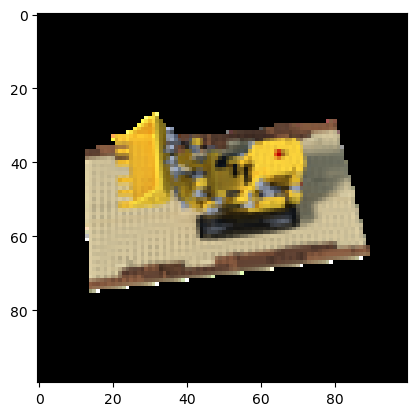

In [4]:
data = np.load('tiny_dnerf_data.npz')
images = data['images'][:,:,:,:3]
poses = data['poses']
focal = data['focal']
times = data['times']

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')
print(f'Times shape: {times.shape}')
print('-'*32)

height, width = images.shape[1:3]
near, far = 2., 6.

n_training = 79
testimg_idx = 80
testimg, testpose, testtime = images[testimg_idx], poses[testimg_idx], times[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)
print('Time')
print(testtime)

# Origins and directions

Recall that NeRF processes inputs from a field of positions (x,y,z) and view directions (θ,φ). To gather these input points, we need to apply inverse rendering to the input images. More concretely, we draw projection lines through each pixel and across the 3D space, from which we can draw samples.

To sample points from the 3D space beyond our image, we first start from the initial pose of every camera taken in the photo set. With some vector math, we can convert these 4x4 pose matrices into a 3D coordinate denoting the origin and a 3D vector indicating the direction. The two together describe a vector that indicates where a camera was pointing when the photo was taken.

The code in the cell below illustrates this by drawing arrows that depict the origin and the direction of every frame.

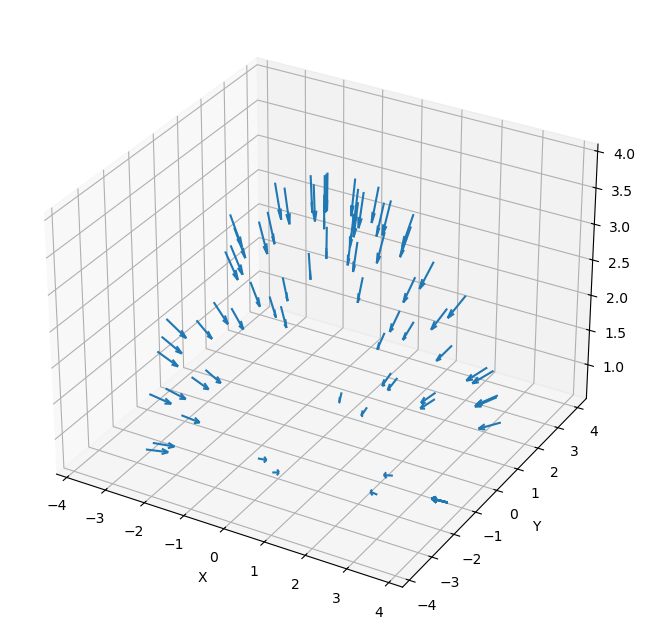

In [5]:
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
	origins[..., 0].flatten(),
	origins[..., 1].flatten(),
	origins[..., 2].flatten(),
	dirs[..., 0].flatten(),
	dirs[..., 1].flatten(),
	dirs[..., 2].flatten(), length=0.5, normalize=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()

With this camera pose, we can now find the projection lines along each pixel of our image. Each line is defined by its origin point (x,y,z) and its direction (in this case a 3D vector). While the origin is the same for every pixel, the direction is slightly different. These lines are slightly deflected off center such that none of these lines are parallel.

![Pinhole camera](https://www.researchgate.net/profile/Willy-Azarcoya-Cabiedes/publication/317498100/figure/fig10/AS:610418494013440@1522546518034/Pin-hole-camera-model-terminology-The-optical-center-pinhole-is-placed-at-the-origin.png)

From [Willy Azarcoya-Cabiedes via ResearchGate](https://www.researchgate.net/figure/Pin-hole-camera-model-terminology-The-optical-center-pinhole-is-placed-at-the-origin_fig10_317498100)

In [6]:
def get_rays(
	height: int,
	width: int,
	focal_length: float,
	c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
	r"""
	Find origin and direction of rays through every pixel and camera origin.
	"""

	# Apply pinhole camera model to gather directions at each pixel
	i, j = torch.meshgrid(
			torch.arange(width, dtype=torch.float32).to(c2w),
			torch.arange(height, dtype=torch.float32).to(c2w),
			indexing='ij')
	i, j = i.transpose(-1, -2), j.transpose(-1, -2)
	directions = torch.stack([(i - width * .5) / focal_length,
														-(j - height * .5) / focal_length,
														-torch.ones_like(i)
													 ], dim=-1)

	# Apply camera pose to directions
	rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

	# Origin is same for all directions (the optical center)
	rays_o = c2w[:3, -1].expand(rays_d.shape)
	return rays_o, rays_d

In [7]:
testpose

array([[ 1.2919170e-01, -9.0707958e-01,  4.0064469e-01,  1.6150504e+00],
       [ 9.9161971e-01,  1.1817751e-01, -5.2197393e-02, -2.1041442e-01],
       [-3.7252907e-09,  4.0403059e-01,  9.1474545e-01,  3.6874568e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [8]:
focal

array(138.8888789)

In [9]:
# Gather as torch tensors
# Training
images = torch.from_numpy(data['images'][:n_training,:,:,:3])
poses = torch.from_numpy(data['poses'][:n_training])
focal = torch.from_numpy(data['focal'])
times = torch.from_numpy(data['times'][:n_training])

# Test
testimg = torch.from_numpy(data['images'][testimg_idx,:,:,:3])
testpose = torch.from_numpy(data['poses'][testimg_idx])
testtime = torch.from_numpy(data['times'][testimg_idx:])

# Grab rays from sample image
height, width = images.shape[1:3]
with torch.no_grad():
	ray_origin, ray_direction = get_rays(height, width, focal, testpose)

print('Ray Origin')
print(ray_origin.shape)
print(ray_origin[height // 2, width // 2, :])
print('')

print('Ray Direction')
print(ray_direction.shape)
print(ray_direction[height // 2, width // 2, :])
print('')

Ray Origin
torch.Size([100, 100, 3])
tensor([ 1.6151, -0.2104,  3.6875])

Ray Direction
torch.Size([100, 100, 3])
tensor([-0.4006,  0.0522, -0.9147])



# Architecture

## Stratified Sampling

Now that we have these lines, defined as origin and direction vectors, we can begin the process of sampling them. Recall that NeRF takes a coarse-to-fine sampling strategy, starting with the stratified sampling approach.

The stratified sampling approach splits the ray into evenly-spaced bins and randomly samples within each bin. The `perturb` setting determines whether to sample points uniformly from each bin or to simply use the bin center as the point. In most cases, we want to keep `perturb = True` as it will encourage the network to learn over a continuously sampled space. It may be useful to disable for debugging.

In [10]:
def sample_stratified(
	rays_o: torch.Tensor,
	rays_d: torch.Tensor,
	near: float,
	far: float,
	n_samples: int,
	perturb: Optional[bool] = True,
	inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
	r"""
	Sample along ray from regularly-spaced bins.
	"""

	# Grab samples for space integration along ray
	t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
	if not inverse_depth:
		# Sample linearly between `near` and `far`
		z_vals = near * (1.-t_vals) + far * (t_vals)
	else:
		# Sample linearly in inverse depth (disparity)
		z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

	# Draw uniform samples from bins along ray
	if perturb:
		mids = .5 * (z_vals[1:] + z_vals[:-1])
		upper = torch.concat([mids, z_vals[-1:]], dim=-1)
		lower = torch.concat([z_vals[:1], mids], dim=-1)
		t_rand = torch.rand([n_samples], device=z_vals.device)
		z_vals = lower + (upper - lower) * t_rand
	z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

	# Apply scale from `rays_d` and offset from `rays_o` to samples
	# pts: (width, height, n_samples, 3)
	pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
	return pts, z_vals

In [11]:
# Draw stratified samples from example
rays_o = ray_origin.view([-1, 3])
rays_d = ray_direction.view([-1, 3])
n_samples = 8
perturb = True
inverse_depth = False
with torch.no_grad():
	pts, z_vals = sample_stratified(
		rays_o, rays_d, 
		near, far, 
		n_samples,
		perturb=perturb, 
		inverse_depth=inverse_depth)

print('Input Points')
print(pts.shape)
print('')
print('Distances Along Ray')
print(z_vals.shape)

Input Points
torch.Size([10000, 8, 3])

Distances Along Ray
torch.Size([10000, 8])


Now we visualize these sampled points. The unperturbed blue points are the bin "centers." The red points are a sampling of perturbed points. Notice how the red points are slightly offset from the blue points above them, but all are constrained between `near` and `far`.

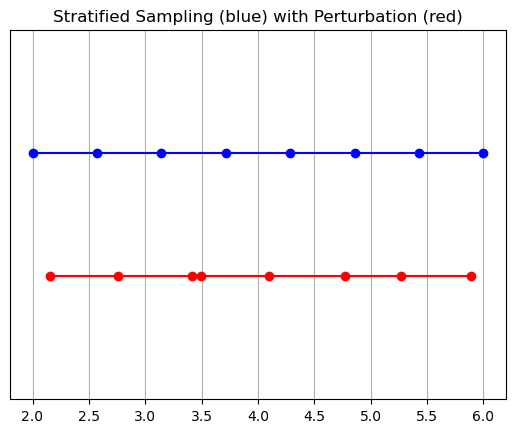

In [12]:
y_vals = torch.zeros_like(z_vals)

_, z_vals_unperturbed = sample_stratified(rays_o, rays_d, near, far, n_samples,
								  perturb=False, inverse_depth=inverse_depth)
plt.plot(z_vals_unperturbed[0].cpu().numpy(), 1 + y_vals[0].cpu().numpy(), 'b-o')
plt.plot(z_vals[0].cpu().numpy(), y_vals[0].cpu().numpy(), 'r-o')
plt.ylim([-1, 2])
plt.title('Stratified Sampling (blue) with Perturbation (red)')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.grid(True)

## Positional Encoder

Much like Transformers, NeRFs make use of positional encoders. In this case, it's to map the inputs to a higher frequency space to compensate for the bias that neural networks have for learning lower-frequency functions.

Here we build a simple `torch.nn.Module` of our positional encoder. The same encoder implementation can be applied to both input samples and view directions. However, we choose different parameters for these inputs. We use the default settings from the original.

In [13]:
class PositionalEncoder(nn.Module):
	r"""
	Sine-cosine positional encoder for input points.
	"""
	def __init__(
		self,
		d_input: int,
		n_freqs: int,
		log_space: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_freqs = n_freqs
		self.log_space = log_space
		self.d_output = d_input * (1 + 2 * self.n_freqs)
		self.embed_fns = [lambda x: x]

		# Define frequencies in either linear or log scale
		if self.log_space:
			freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
		else:
			freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

		# Alternate sin and cos
		for freq in freq_bands:
			self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
			self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

	def forward(
		self,
		x
	) -> torch.Tensor:
		r"""
		Apply positional encoding to input.
		"""
		return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)


## NeRF Model

Here we define the NeRF model, which consists primarily of a `ModuleList` of `Linear` layers, separated by non-linear activation functions and the occasional residual connection. This model features an optional input for view directions, which will alter the model architecture if provided at instantiation. This implementation is based on Section 3 of the original "NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis" paper and uses the same defaults.

In [14]:
class NeRF(nn.Module):
	r"""
	Neural radiance fields module.
	"""
	def __init__(
		self,
		d_input: int = 3,
		n_layers: int = 8,
		d_filter: int = 256,
		skip: Tuple[int] = (4,),
		d_viewdirs: Optional[int] = None
	):
		super().__init__()
		self.d_input = d_input
		self.skip = skip
		self.act = nn.functional.relu
		self.d_viewdirs = d_viewdirs

		# Create model layers
		self.layers = nn.ModuleList(
			[nn.Linear(self.d_input, d_filter)] +
			[nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
			 else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
		)

		# Bottleneck layers
		if self.d_viewdirs is not None:
			# If using viewdirs, split alpha and RGB
			self.alpha_out = nn.Linear(d_filter, 1)
			self.rgb_filters = nn.Linear(d_filter, d_filter)
			self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
			self.output = nn.Linear(d_filter // 2, 3)
		else:
			# If no viewdirs, use simpler output
			self.output = nn.Linear(d_filter, 4)

	def forward(
		self,
		x: torch.Tensor,
		viewdirs: Optional[torch.Tensor] = None
	) -> torch.Tensor:
		r"""
		Forward pass with optional view direction.
		"""

		# Cannot use viewdirs if instantiated with d_viewdirs = None
		if self.d_viewdirs is None and viewdirs is not None:
			raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

		# Apply forward pass up to bottleneck
		x_input = x
		for i, layer in enumerate(self.layers):
			x = self.act(layer(x))
			if i in self.skip:
				x = torch.cat([x, x_input], dim=-1)

		# Apply bottleneck
		if self.d_viewdirs is not None:
			# Split alpha from network output
			alpha = self.alpha_out(x)

			# Pass through bottleneck to get RGB
			x = self.rgb_filters(x)
			x = torch.concat([x, viewdirs], dim=-1)
			x = self.act(self.branch(x))
			x = self.output(x)

			# Concatenate alphas to output
			x = torch.concat([x, alpha], dim=-1)
		else:
			# Simple output
			x = self.output(x)
		return x

## Dynamic NeRF model
description pending

In [15]:
for i in range(1,5):
    print(i)

1
2
3
4


In [16]:
class DNeRF(nn.Module):
	r"""Dynamic Neural radiance fields module.
	"""
	def __init__(self,
		d_input: int = 3,
		n_layers: int = 8,
		d_filter: int = 256,
		skip: Tuple[int] = (4,),
		d_viewdirs: Optional[int] = None,

		d_time: int = 1,
		encode: Callable = None,
		zero_canonical: bool = False
	):
		super().__init__()
		self.d_input = d_input
		self.n_layers = n_layers
		self.d_filter = d_filter
		self.skip = skip
		self.act = nn.ReLU()
		# Time network
		self.d_time = d_time
		self.encode = encode
		self.zero_canonical = zero_canonical

		# Defining original nerf nodel
		self.nerf_model = NeRF(d_input, n_layers, d_filter, skip, d_viewdirs)
		# Defining time deformation network
		self.deformation_model = self._create()
		

	def _create(self):
		input_dimention = self.d_input+self.d_time
		
		layers = [nn.Linear(input_dimention, self.d_filter)]
		for i in range(1, self.n_layers):
			if i in self.skip:
				layers += [nn.Linear(self.d_filter+input_dimention, self.d_filter)]
			else:
				layers += [nn.Linear(self.d_filter, self.d_filter)]
		layers += [nn.Linear(self.d_filter, 3)]

		layers = nn.ModuleList(layers)
		return layers 
	
	def _query_time(self, x: torch.Tensor) -> torch.Tensor:
		original_input = x
		for i, layer in enumerate(self.deformation_model):
			if i in self.skip:
				x = torch.cat([original_input, x], -1)
			
			x = layer(x)
			
			if i < len(self.deformation_model)-1:
				x = self.act(x)
		return x

	def forward(
		self,
		x: torch.Tensor,
		timesteps: torch.Tensor,
		viewdirs: Optional[torch.Tensor] = None,
	) -> torch.Tensor:
		r"""
		Forward pass through time deformation network and NeRF
		"""
		
		debug('DNERF INPUTS: '+str(x.shape) +' ; '+ str(timesteps.shape))
		inputs = torch.cat([x, timesteps], -1)
		dx = self._query_time(inputs)
		if self.zero_canonical:
			cond = timesteps[:,0] == 0
			dx[cond] = 0.0

		original_points = x[:,:3]
		points_dx = original_points + dx
		points_dx = self.encode(points_dx)

		output = self.nerf_model(points_dx, viewdirs)

		return output

In [17]:
# DNeRF network test
X = torch.randn(10,3)#.to(device)
V = torch.randn(10,3)#.to(device)
T = torch.randn(10,1)#.to(device)

T[[0,1,2,3]] = 0

# Encoders
encoder = PositionalEncoder(3, 10)
encode = lambda x: encoder(x)
encoder_time = PositionalEncoder(1, 4)
encode_time = lambda x: encoder_time(x)


X = encode(X)
V = encode(V)
T = encode_time(T)

dnerf = DNeRF(
			d_input = encoder.d_output, 
			n_layers=6, 
			d_filter=128, 
			skip=[3],
			d_viewdirs=encoder.d_output,
			d_time=encoder_time.d_output,
			encode=encode,
			zero_canonical=True)
print(dnerf)
dnerf(X,T,V).shape

DNeRF(
  (act): ReLU()
  (nerf_model): NeRF(
    (layers): ModuleList(
      (0): Linear(in_features=63, out_features=128, bias=True)
      (1-3): 3 x Linear(in_features=128, out_features=128, bias=True)
      (4): Linear(in_features=191, out_features=128, bias=True)
      (5): Linear(in_features=128, out_features=128, bias=True)
    )
    (alpha_out): Linear(in_features=128, out_features=1, bias=True)
    (rgb_filters): Linear(in_features=128, out_features=128, bias=True)
    (branch): Linear(in_features=191, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=3, bias=True)
  )
  (deformation_model): ModuleList(
    (0): Linear(in_features=72, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=200, out_features=128, bias=True)
    (4-5): 2 x Linear(in_features=128, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)


torch.Size([10, 4])

## Volume Rendering

From the raw NeRF outputs, we still need to convert these into an image. This is where we apply the volume integration described in Equations 1-3 in Section 4 of the paper. Essentially, we take the weighted sum of all samples along the ray of each pixel to get the estimated color value at that pixel. Each RGB sample is weighted by its alpha value. Higher alpha values indicate higher likelihood that the sampled area is opaque, therefore points further along the ray are likelier to be occluded. The cumulative product ensures that those further points are dampened.

In [18]:
def cumprod_exclusive(
	tensor: torch.Tensor
) -> torch.Tensor:
	r"""
	(Courtesy of https://github.com/krrish94/nerf-pytorch)

	Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

	Args:
	tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
		is to be computed.
	Returns:
	cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
		tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
	"""

	# Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
	cumprod = torch.cumprod(tensor, -1)
	# "Roll" the elements along dimension 'dim' by 1 element.
	cumprod = torch.roll(cumprod, 1, -1)
	# Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
	cumprod[..., 0] = 1.

	return cumprod

def raw2outputs(
	raw: torch.Tensor,
	z_vals: torch.Tensor,
	rays_d: torch.Tensor,
	raw_noise_std: float = 0.0,
	white_bkgd: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
	r"""
	Convert the raw NeRF output into RGB and other maps.
	"""

	# Difference between consecutive elements of `z_vals`. [n_rays, n_samples]
	dists = z_vals[..., 1:] - z_vals[..., :-1]
	dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1)

	# Multiply each distance by the norm of its corresponding direction ray
	# to convert to real world distance (accounts for non-unit directions).
	dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

	# Add noise to model's predictions for density. Can be used to
	# regularize network during training (prevents floater artifacts).
	noise = 0.
	if raw_noise_std > 0.:
		noise = torch.randn(raw[..., 3].shape) * raw_noise_std

	# Predict density of each sample along each ray. Higher values imply
	# higher likelihood of being absorbed at this point. [n_rays, n_samples]
	alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 3] + noise) * dists)

	# Compute weight for RGB of each sample along each ray. [n_rays, n_samples]
	# The higher the alpha, the lower subsequent weights are driven.
	weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

	# Compute weighted RGB map.
	rgb = torch.sigmoid(raw[..., :3])  # [n_rays, n_samples, 3]
	rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [n_rays, 3]

	# Estimated depth map is predicted distance.
	depth_map = torch.sum(weights * z_vals, dim=-1)

	# Disparity map is inverse depth.
	disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map),
														depth_map / torch.sum(weights, -1))

	# Sum of weights along each ray. In [0, 1] up to numerical error.
	acc_map = torch.sum(weights, dim=-1)

	# To composite onto a white background, use the accumulated alpha map.
	if white_bkgd:
		rgb_map = rgb_map + (1. - acc_map[..., None])

	return rgb_map, depth_map, acc_map, weights

## Hierarchical Volume Sampling

The 3D space is in fact very sparse with occlusions and so most points don't contribute much to the rendered image. It is therefore more beneficial to oversample regions with a high likelihood of contributing to the integral. Here we apply learned, normalized weights to the first set of samples to create a PDF across the ray, then apply inverse transform sampling to this PDF to gather a second set of samples.

In [19]:
def sample_pdf(
	bins: torch.Tensor,
	weights: torch.Tensor,
	n_samples: int,
	perturb: bool = False
) -> torch.Tensor:
	r"""
	Apply inverse transform sampling to a weighted set of points.
	"""

	# Normalize weights to get PDF.
	pdf = (weights + 1e-5) / torch.sum(weights + 1e-5, -1, keepdims=True) # [n_rays, weights.shape[-1]]

	# Convert PDF to CDF.
	cdf = torch.cumsum(pdf, dim=-1) # [n_rays, weights.shape[-1]]
	cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, weights.shape[-1] + 1]

	# Take sample positions to grab from CDF. Linear when perturb == 0.
	if not perturb:
		u = torch.linspace(0., 1., n_samples, device=cdf.device)
		u = u.expand(list(cdf.shape[:-1]) + [n_samples]) # [n_rays, n_samples]
	else:
		u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

	# Find indices along CDF where values in u would be placed.
	u = u.contiguous() # Returns contiguous tensor with same values.
	inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

	# Clamp indices that are out of bounds.
	below = torch.clamp(inds - 1, min=0)
	above = torch.clamp(inds, max=cdf.shape[-1] - 1)
	inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

	# Sample from cdf and the corresponding bin centers.
	matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
	cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,
											 index=inds_g)
	bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,
												index=inds_g)

	# Convert samples to ray length.
	denom = (cdf_g[..., 1] - cdf_g[..., 0])
	denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
	t = (u - cdf_g[..., 0]) / denom
	samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

	return samples # [n_rays, n_samples]

In [20]:
def sample_hierarchical(
	rays_o: torch.Tensor,
	rays_d: torch.Tensor,
	z_vals: torch.Tensor,
	weights: torch.Tensor,
	n_samples: int,
	perturb: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
	r"""
	Apply hierarchical sampling to the rays.
	"""

	# Draw samples from PDF using z_vals as bins and weights as probabilities.
	z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
	new_z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], n_samples,
													perturb=perturb)
	new_z_samples = new_z_samples.detach()

	# Resample points from ray based on PDF.
	z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
	pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + n_samples, 3]
	return pts, z_vals_combined, new_z_samples

## Full Forward Pass

Here is where we put everything together to compute a single forward pass through our model.

Due to potential memory issues, the forward pass is computed in "chunks," which are then aggregated across a single batch. The gradient propagation is done after the whole batch is processed, hence the distinction between "chunks" and "batches." Chunking is especially important for the Google Colab environment, which provides more modest resources than those cited in the original paper.

In [21]:
def get_chunks(
	inputs: torch.Tensor,
	chunksize: int = 2**15
) -> List[torch.Tensor]:
	r"""
	Divide an input into chunks.
	"""
	return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def prepare_chunks(
	points: torch.Tensor,
	encoding_function: Callable[[torch.Tensor], torch.Tensor],
	chunksize: int = 2**15
) -> List[torch.Tensor]:
	r"""
	Encode and chunkify points to prepare for NeRF model.
	"""
	points = points.reshape((-1, 3))
	points = encoding_function(points)
	points = get_chunks(points, chunksize=chunksize)
	return points

def prepare_viewdirs_chunks(
	points: torch.Tensor,
	rays_d: torch.Tensor,
	encoding_function: Callable[[torch.Tensor], torch.Tensor],
	chunksize: int = 2**15
) -> List[torch.Tensor]:
	r"""
	Encode and chunkify viewdirs to prepare for NeRF model.
	"""
	# Prepare the viewdirs
	viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
	viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
	viewdirs = encoding_function(viewdirs)
	viewdirs = get_chunks(viewdirs, chunksize=chunksize)
	return viewdirs

def prepare_time(
	timesteps, 
	time_encoding_fn: Callable[[torch.Tensor], torch.Tensor], 
	chunksize: int = 2**15
) -> List[torch.Tensor]:
	r"""
	Encode and chunkify timepoints to prepare for NeRF model.
	"""
	timesteps = time_encoding_fn(timesteps)
	timesteps = get_chunks(timesteps, chunksize=chunksize)
	return timesteps

In [22]:
def nerf_forward(
	rays_o: torch.Tensor,
	rays_d: torch.Tensor,
	timesteps: torch.Tensor,
	near: float,
	far: float,
	encoding_fn: Callable[[torch.Tensor], torch.Tensor],
	coarse_model: nn.Module,
	kwargs_sample_stratified: dict = None,
	n_samples_hierarchical: int = 0,
	kwargs_sample_hierarchical: dict = None,
	fine_model = None,
	viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
	time_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
	chunksize: int = 2**15
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
	r"""
	Compute forward pass through model(s).
	"""
	# Set no kwargs if none are given.
	if kwargs_sample_stratified is None:
		kwargs_sample_stratified = {}
	if kwargs_sample_hierarchical is None:
		kwargs_sample_hierarchical = {}

	# Sample query points along each ray.
	query_points, z_vals = sample_stratified(
			rays_o, rays_d, near, far, **kwargs_sample_stratified)
	# Prepare batches.
	batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
	if viewdirs_encoding_fn is not None:
		batches_viewdirs = prepare_viewdirs_chunks(
			query_points, rays_d,
			viewdirs_encoding_fn,
			chunksize=chunksize)
	else:
		batches_viewdirs = [None] * len(batches)

	# Time
	if timesteps.shape[0] == 1: # only one image and one timestep
		# Expanding to match other data
		n_points = query_points.reshape(-1,3).shape[0]
		expanded_timesteps = timesteps.expand(n_points).reshape(-1,1)
	else: # For each ray repeating timestep along sampling dimention
		n_rays = query_points.shape[1]
		expanded_timesteps = timesteps.repeat(1,n_rays).reshape(-1,1)
	batches_times = prepare_time(expanded_timesteps, time_encoding_fn, chunksize)
	
	###
	# Coarse model pass.
	# Split the encoded points into "chunks", run the model on all chunks, and
	# concatenate the results (to avoid out-of-memory issues).
	predictions = []
	for batch, batch_viewdirs, batch_time in zip(batches, batches_viewdirs, batches_times):
		# batch, batch_viewdirs, batch_time  = batch.contiguous(), batch_viewdirs.contiguous(), batch_time.contiguous()
		batch, batch_viewdirs, batch_time  = batch.to(device), batch_viewdirs.to(device), batch_time.to(device)
		one_batch_prediction = coarse_model(batch, viewdirs=batch_viewdirs, timesteps=batch_time)
		predictions.append(one_batch_prediction)

	debug('Predictions length: '+str(len(predictions)))
	raw = torch.cat(predictions, dim=0)
	
	raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])
	raw = raw.to('cpu')

	# Perform differentiable volume rendering to re-synthesize the RGB image.
	rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals, rays_d)
	# rgb_map, depth_map, acc_map, weights = render_volume_density(raw, rays_o, z_vals)

	outputs = {
			'z_vals_stratified': z_vals
	}

	###
	# Fine model pass.
	debug('Fine model pass\n')
	if n_samples_hierarchical > 0:
		# Save previous outputs to return.
		rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map

		# Apply hierarchical sampling for fine query points.
		query_points, z_vals_combined, z_hierarch = sample_hierarchical(
			rays_o, rays_d, z_vals, weights, n_samples_hierarchical,
			**kwargs_sample_hierarchical)

		# Prepare inputs as before.
		batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
		if viewdirs_encoding_fn is not None:
			batches_viewdirs = prepare_viewdirs_chunks(
				query_points, rays_d,
				viewdirs_encoding_fn,
				chunksize=chunksize)
		else:
			batches_viewdirs = [None] * len(batches)

		# Time
		if timesteps.shape[0] == 1: # only one image and one timestep
			# Expanding to match other data
			n_points = query_points.reshape(-1,3).shape[0]
			expanded_timesteps = timesteps.expand(n_points).reshape(-1,1)
		else: # For each ray repeating timestep along sampling dimention
			n_rays = query_points.shape[1]
			expanded_timesteps = timesteps.repeat(1,n_rays).reshape(-1,1)
		batches_times = prepare_time(expanded_timesteps, time_encoding_fn, chunksize)

		# Forward pass new samples through fine model.
		fine_model = fine_model if fine_model is not None else coarse_model
		predictions = []
		for batch, batch_viewdirs, batch_time in zip(batches, batches_viewdirs, batches_times):
			# batch, batch_viewdirs, batch_time  = batch.contiguous(), batch_viewdirs.contiguous(), batch_time.contiguous()
			batch, batch_viewdirs, batch_time  = batch.to(device), batch_viewdirs.to(device), batch_time.to(device)
			one_batch_predictions = fine_model(batch, viewdirs=batch_viewdirs, timesteps=batch_time)
			predictions.append(one_batch_predictions)
		raw = torch.cat(predictions, dim=0)
		raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])
		raw = raw.to('cpu')

		# Perform differentiable volume rendering to re-synthesize the RGB image.
		rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)

		# Store outputs.
		outputs['z_vals_hierarchical'] = z_hierarch
		outputs['rgb_map_0'] = rgb_map_0
		outputs['depth_map_0'] = depth_map_0
		outputs['acc_map_0'] = acc_map_0

	# Store outputs.
	outputs['rgb_map'] = rgb_map
	outputs['depth_map'] = depth_map
	outputs['acc_map'] = acc_map
	outputs['weights'] = weights
	return outputs

# Train

At long last, we have (almost) everything we need to train the model. Now we will do some setup for a simple training procedure, creating hyperparameters and helper functions, then train our model.

## Hyperparameters

All hyperparameters for training are set here. Defaults were taken from the original, unless computational constraints prohibit them. In this case, we apply sensible defaults that are well within the resources provided by Google Colab.

In [23]:
# Encoders
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 10    # Number of encoding functions for views
n_freqs_time = 10     # Number of encoding functions for time

# Stratified sampling
n_samples = 64         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model
d_filter = 128          # Dimensions of linear layer filters
n_layers = 2            # Number of layers in network bottleneck
skip = []               # Layers at which to apply input residual
use_fine_model = True   # If set, creates a fine model
d_filter_fine = 128     # Dimensions of linear layer filters of fine network
n_layers_fine = 6       # Number of layers in fine network bottleneck 
skip_fine = []			# Layers at which to apply input residual of fine network
zero_canonical = True  # Use timestep 0 for a canonical space representation for D-NeRF

# Hierarchical sampling
n_samples_hierarchical = 64 #64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

# Optimizer
lr = 5e-4  								 # Learning rate
scheduler_start_end_factors = [1.0, 0.9] # Linear decay of learning rate

# Training
n_iters = 10000
batch_size = 2**14          # Number of rays per gradient step (power of 2)
one_image_per_step = [True,False][1]   # One image per gradient step (disables batching)
chunksize = 2**14           # Modify as needed to fit in GPU memory
center_crop = True          # Crop the center of image (one_image_per_)
center_crop_iters = 50      # Stop cropping center after this many epochs
display_rate = 50          # Display test output every X epochs
shuffle_data = True		# Shuffle rays on every iteration. Mostly for debug. Default: True

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {
	'n_samples': n_samples,
	'perturb': perturb,
	'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
	'perturb': perturb
}

## Training Classes and Functions

Here we create some helper functions for training. NeRF can be prone to local minima, in which training will quickly stall and produce blank outputs. `EarlyStopping` is used to restart the training when learning stalls, if necessary.

In [24]:
def plot_samples(
	z_vals: torch.Tensor,
	z_hierarch: Optional[torch.Tensor] = None,
	ax: Optional[np.ndarray] = None):
	r"""
	Plot stratified and (optional) hierarchical samples.
	"""
	y_vals = 1 + np.zeros_like(z_vals)

	if ax is None:
		ax = plt.subplot()
	ax.plot(z_vals, y_vals, 'b-o')
	if z_hierarch is not None:
		y_hierarch = np.zeros_like(z_hierarch)
		ax.plot(z_hierarch, y_hierarch, 'r-o')
	ax.set_ylim([-1, 2])
	ax.set_title('Stratified  Samples (blue) and Hierarchical Samples (red)')
	ax.axes.yaxis.set_visible(False)
	ax.grid(True)
	return ax

def crop_center(
	img: torch.Tensor,
	frac: float = 0.5
) -> torch.Tensor:
	r"""
	Crop center square from image.
	"""
	h_offset = round(img.shape[0] * (frac / 2))
	w_offset = round(img.shape[1] * (frac / 2))
	return img[h_offset:-h_offset, w_offset:-w_offset]

class EarlyStopping:
	r"""
	Early stopping helper based on fitness criterion.
	"""
	def __init__(
		self,
		patience: int = 30,
		margin: float = 1e-4
	):
		self.best_fitness = 0.0  # In our case PSNR
		self.best_iter = 0
		self.margin = margin
		self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop

	def __call__(
		self,
		iter: int,
		fitness: float
	):
		r"""
		Check if criterion for stopping is met.
		"""
		if (fitness - self.best_fitness) > self.margin:
			self.best_iter = iter
			self.best_fitness = fitness
		delta = iter - self.best_iter
		stop = delta >= self.patience  # stop training if patience exceeded
		return stop

In [25]:
def init_models():
	r"""
	Initialize models, encoders, and optimizer for NeRF training.
	"""
	# Encoders
	encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
	encode = lambda x: encoder(x)

	# View direction encoders
	if use_viewdirs:
		encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,
																				log_space=log_space)
		encode_viewdirs = lambda x: encoder_viewdirs(x)
		d_viewdirs = encoder_viewdirs.d_output
	else:
		encode_viewdirs = None
		d_viewdirs = None

    # Time encoder
	encoder_time = PositionalEncoder(1, n_freqs_time, log_space=log_space)
	encode_time = lambda x: encoder_time(x)
	d_timesteps = encoder_time.d_output

	# Models
	model = DNeRF(
			d_input = encoder.d_output, 
			n_layers = n_layers, 
			d_filter = d_filter, 
			skip = skip,
			d_viewdirs = d_viewdirs,
			d_time = d_timesteps,
			encode = encode,
			zero_canonical=zero_canonical)
	debug('Coarse model\n'+str(model))
	model.to(device)
	model_params = list(model.parameters())
	if use_fine_model:
		fine_model = DNeRF(
					d_input = encoder.d_output, 
					n_layers=n_layers_fine, 
					d_filter=d_filter_fine, 
					skip=skip_fine,
					d_viewdirs=d_viewdirs,
					d_time=d_timesteps,
					encode=encode,
					zero_canonical=zero_canonical)
		debug('Fine model\n'+str(fine_model))
		fine_model.to(device)
		model_params = model_params + list(fine_model.parameters())
	else:
		fine_model = None

	# Optimizer
	optimizer = torch.optim.Adam(model_params, lr=lr)

	# Early Stopping
	warmup_stopper = EarlyStopping(patience=50)

	# Scheduler 
	scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 
			start_factor=scheduler_start_end_factors[0], 
			end_factor=scheduler_start_end_factors[1], 
			total_iters=n_iters)

	return model, fine_model, encode, encode_viewdirs, encode_time, optimizer, warmup_stopper, scheduler

## Training Loop

Here we start training our model.

In [26]:
def train_one_time(i, i_batch, rays_rgb=None, time_bundle=None):
	debug('\n--------------------START DATA BACHIFY--------------------\n')
	model.train()

	if one_image_per_step:
		# Randomly pick an image as the target.
		# Target Image
		target_img_idx = np.random.randint(images.shape[0])
		target_img = images[target_img_idx]
		if center_crop and i < center_crop_iters:
			target_img = crop_center(target_img)
		height, width = target_img.shape[:2]
		target_img = target_img.reshape([-1, 3])
		# Pose
		target_pose = poses[target_img_idx]#.to(device)
		# Rays
		rays_o, rays_d = get_rays(height, width, focal, target_pose)
		rays_o = rays_o.reshape([-1, 3])#.to(device)
		rays_d = rays_d.reshape([-1, 3])#.to(device)
		# Handle Time
		timesteps = times[target_img_idx].reshape(1)
	else:
		debug('iteration: '+str(i)+'; batch number: '+str(i_batch)+'; Batch size: '+str(batch_size))
		# Reset and Shuffle at the beggining of batchify
		if i_batch >= rays_rgb.shape[0]:
				# debug('Batch reset!!!')
				i_batch = 0
				if shuffle_data:
					rand_indexes = torch.randperm(rays_rgb.shape[0])
					rays_rgb = rays_rgb[rand_indexes]
					time_bundle = time_bundle[rand_indexes]
		# Random over all images.
		batch = rays_rgb[i_batch:i_batch + batch_size]
		batch = torch.transpose(batch, 0, 1)#.to(device)
		rays_o, rays_d, target_img = batch
		height, width = target_img.shape[:2]
		
		# Handle Time
		timesteps = time_bundle[i_batch:i_batch + batch_size]
		
		debug('timesteps shape: '+str(timesteps.shape))
		debug('timesteps:\n'+str(timesteps[9950:10050].T))

		# This should be last!
		i_batch += batch_size
	debug('rays_o shape: '+str(rays_o.shape))
	debug('rays_d shape: '+str(rays_d.shape))
	debug('\n--------------------END DATA BACHIFY--------------------\n')


	# Run one iteration of TinyNeRF and get the rendered RGB image.
	outputs = nerf_forward(
		rays_o, rays_d, timesteps,
        near, far, encode, model,
        kwargs_sample_stratified=kwargs_sample_stratified,
        n_samples_hierarchical=n_samples_hierarchical,
        kwargs_sample_hierarchical=kwargs_sample_hierarchical,
        fine_model=fine_model,
        viewdirs_encoding_fn=encode_viewdirs,
		time_encoding_fn=encode_time,
        chunksize=chunksize)

	# Check for any numerical issues.
	for k, v in outputs.items():
		if torch.isnan(v).any():
			print(f"! [Numerical Alert] {k} contains NaN.")
		if torch.isinf(v).any():
			print(f"! [Numerical Alert] {k} contains Inf.")

	# Backprop!
	rgb_predicted = outputs['rgb_map']
	loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
	loss.backward()
	optimizer.step()
	optimizer.zero_grad()
	psnr = -10. * torch.log10(loss)
	scheduler.step()
	
	return psnr.item(), i_batch

In [27]:
def eval_one_time(i, iternums, train_psnrs, val_psnrs):
	model.eval()
	height, width = testimg.shape[:2]
	rays_o, rays_d = get_rays(height, width, focal, testpose)
	rays_o = rays_o.reshape([-1, 3])#.to(device)
	rays_d = rays_d.reshape([-1, 3])#.to(device)
	outputs = nerf_forward(rays_o, rays_d, testtime,
							near, far, encode, model,
							kwargs_sample_stratified=kwargs_sample_stratified,
							n_samples_hierarchical=n_samples_hierarchical,
							kwargs_sample_hierarchical=kwargs_sample_hierarchical,
							fine_model=fine_model,
							viewdirs_encoding_fn=encode_viewdirs,
							time_encoding_fn=encode_time,
							chunksize=chunksize)

	rgb_predicted = outputs['rgb_map']
	testimg_flat = testimg.reshape(-1, 3)#.to(device)
	loss = torch.nn.functional.mse_loss(rgb_predicted, testimg_flat)
	print("Loss:", loss.item())
	val_psnr = -10. * torch.log10(loss)
	val_psnrs.append(val_psnr.item())
	iternums.append(i)

	# Plot example outputs outside
	render(i, rgb_predicted, iternums, outputs,train_psnrs,val_psnrs)

In [28]:
def render(i, rgb_predicted, iternums, outputs,train_psnrs,val_psnrs):
	fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 3]})
    # Plot example outputs
	
	ax[0].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
	ax[0].set_title(f'Iteration: {i}')
	ax[1].imshow(testimg.detach().cpu().numpy())
	ax[1].set_title(f'Target\nTest timestep: {testtime[0].item()}')
	ax[2].plot(range(0, i + 1), train_psnrs, 'r')
	ax[2].plot(iternums, val_psnrs, 'b')
	ax[2].set_title('PSNR (train=red, val=blue')
	z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
	z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
	if 'z_vals_hierarchical' in outputs:
		z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
		z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
	else:
		z_sample_hierarch = None
	_ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[3])
	ax[3].margins(0)
	plt.show()
    

In [29]:
# TIME BUNDLE TEST
height, width = images.shape[1:3]
all_rays = torch.stack([torch.stack(get_rays(height, width, focal, p), 0)
		for p in poses[:n_training]], 0) # [N, ro+rd, H, W, 3]
rays_rgb = torch.cat([all_rays, images[:, None]], 1) # [N, ro+rd+rgb, H, W, 3]
rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4]) # [N, H, W, ro+rd+rgb, 3]
rays_rgb = rays_rgb.reshape([-1, 3, 3]) # [(N-1)*H*W, ro+rd+rgb, 3]
# rays_rgb = rays_rgb.type(torch.float32)
print(rays_rgb.shape, all_rays.shape)

# One image is 10000 points
A,_,C,D,_ = all_rays.shape
time_bundle_shape = (A,C,D,1)
time_bundle = torch.zeros(time_bundle_shape)
for i,_t in enumerate(times):
    time_bundle[i] += _t # fill time bundle 
time_bundle = time_bundle.reshape(-1, 1) 
time_bundle.shape


torch.Size([790000, 3, 3]) torch.Size([79, 2, 100, 100, 3])


torch.Size([790000, 1])

In [30]:
def train():
	r"""
	Launch training session for NeRF.
	"""
	# Shuffle rays across all images.
	i_batch = 0
	rays_rgb = None
	time_bundle = None
	if not one_image_per_step:
		height, width = images.shape[1:3]
		all_rays = torch.stack([torch.stack(get_rays(height, width, focal, p), 0)
				for p in poses[:n_training]], 0) # [N, ro+rd, H, W, 3]
		rays_rgb = torch.cat([all_rays, images[:, None]], 1) # [N, ro+rd+rgb, H, W, 3]
		rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4]) # [N, H, W, ro+rd+rgb, 3]
		rays_rgb = rays_rgb.reshape([-1, 3, 3]) # [(N-1)*H*W, ro+rd+rgb, 3]
		rays_rgb = rays_rgb.type(torch.float32)
		if shuffle_data:
			rand_indexes = torch.randperm(rays_rgb.shape[0])
			rays_rgb = rays_rgb[rand_indexes]

		# Create batch expended time. 
		# Each ray has time, corresponede to image timestep 
		A,_,C,D,_ = all_rays.shape # [N, _, H, W, _]
		time_bundle_shape = (A,C,D,1) # [N, H, W, 1]
		time_bundle = torch.zeros(time_bundle_shape)
		for i,_t in enumerate(times):
			time_bundle[i] += _t # fill time bundle 
		time_bundle = time_bundle.reshape(-1, 1) # [N*H*W, 1]
		if shuffle_data:
			# same shuffle that we use for rays!
			time_bundle = time_bundle[rand_indexes] 
		
	train_psnrs = []
	val_psnrs = []
	iternums = []
	
	debug('\n--------------------INITIAL SHUFFLE--------------------\n')
	debug('rays_rgb shape in :'+str(rays_rgb.shape))
	debug('time_bundle shape in :'+str(time_bundle.shape))

	debug('time_bundle\n'+str(time_bundle[9950:10050].T))
	

	for i in trange(n_iters):
		
		psnr, i_batch = train_one_time(i, i_batch, rays_rgb, time_bundle)
		train_psnrs.append(psnr)

		# Evaluate testimg at given display rate.
		if i % display_rate == 0:
			eval_one_time(i, iternums, train_psnrs, val_psnrs)

		# Check PSNR for issues and stop if any are found.
		val_psnr = val_psnrs[-1]
		if i == warmup_iters - 1:
			if val_psnr < warmup_min_fitness:
				print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
				return False, train_psnrs, val_psnrs
		elif i < warmup_iters:
			if warmup_stopper is not None and warmup_stopper(i, psnr):
				print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
				return False, train_psnrs, val_psnrs
	
		# break # TODO:REMOVE

	print('val_psnrs',val_psnrs)
	return True, train_psnrs, val_psnrs

In [31]:
# Run training session(s)
for _ in range(n_restarts):
	model, fine_model, encode, encode_viewdirs, encode_time, optimizer, warmup_stopper, scheduler=init_models()
	success, train_psnrs, val_psnrs = train()
	if success and val_psnrs[-1] >= warmup_min_fitness:
		print('Training successful!')
		break
	# break # TODO:REMOVE

print('')
print(f'Done!')

  0%|          | 0/10000 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU  has a total capacity of 23.69 GiB of which 3.88 MiB is free. Including non-PyTorch memory, this process has 23.67 GiB memory in use. Of the allocated memory 20.64 GiB is allocated by PyTorch, and 2.73 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.save(model.state_dict(), 'd-nerf.pt')
torch.save(fine_model.state_dict(), 'd-nerf-fine.pt')

# Evaluation and Plotting